In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Literal

np.random.seed(1)

In [2]:
# Need Arima to understand this
# See extra_reading.txt
x0 = 1 / (1 - 0.9)
sigma = 1   # standard deviation
data = [x0]

for t in range(300):
    x1 = 1 + 0.9 * x0 + np.random.normal(0, sigma)
    data.append(x1)
    x0 = x1

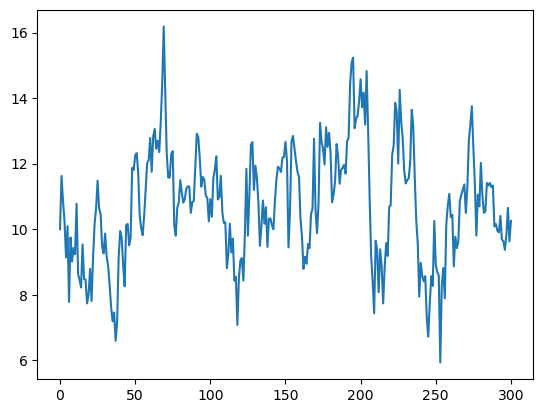

In [3]:
# this hould be like a mean reverting process
plt.plot(data)

In [4]:
series = pd.Series(data)
series

0      10.000000
1      11.624345
2      10.850154
3      10.236967
4       9.140302
         ...    
296     9.369898
297     9.850210
298    10.649959
299     9.629538
300    10.252495
Length: 301, dtype: float64

<AxesSubplot: >

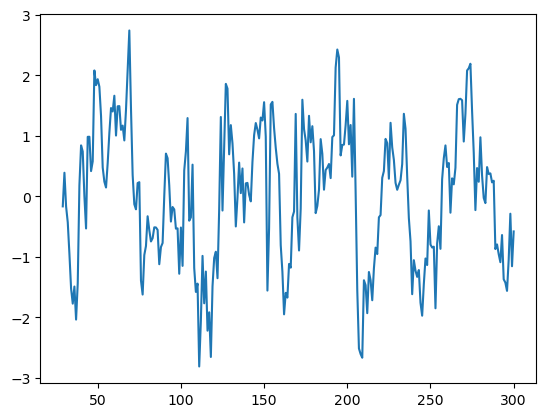

In [5]:
z = (series - series.rolling(30).mean()) / series.rolling(30).std()
# z = (series - series.mean()) / series.std()
z.plot()

The value `1.96` is used in statistics as a multiplier for standard deviations when creating a 95% confidence interval for a normal distribution. 

In a normal distribution:
- Approximately 68% of data falls within 1 standard deviation of the mean.
- Approximately 95% of data falls within 1.96 standard deviations of the mean.
- Approximately 99.7% of data falls within 3 standard deviations of the mean.

So, in the code you provided, `upper_bound` and `lower_bound` are being calculated as the mean plus or minus 1.96 standard deviations. This means that the range between `lower_bound` and `upper_bound` should contain about 95% of the data points in `z`, assuming `z` follows a normal distribution. 

This is a common technique used in statistics for anomaly detection, where values that fall outside of this range could be considered anomalies or outliers.

In [6]:
z_mean = z.rolling(window=30).mean()
z_std = z.rolling(window=30).std()
upper_bound = z_mean + 1.96 * z_std
lower_bound = z_mean - 1.96 * z_std

In [7]:
def plot_basic(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ax.plot(z, label="z")
    ax.plot(z_mean, label="z_mean")
    ax.plot(upper_bound, label="upper_bound")
    ax.plot(lower_bound, label="lower_bound")


def make_subplots(series: List[pd.Series], names: List[str], title: str = ""):
    fig, ax = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
    plot_basic(ax[0])
    fig.suptitle(title)
    fig.tight_layout()

    for s, n in zip(series, names):
        ax[1].plot(s, label=n)

    # show both legends
    ax[0].legend()
    ax[1].legend()

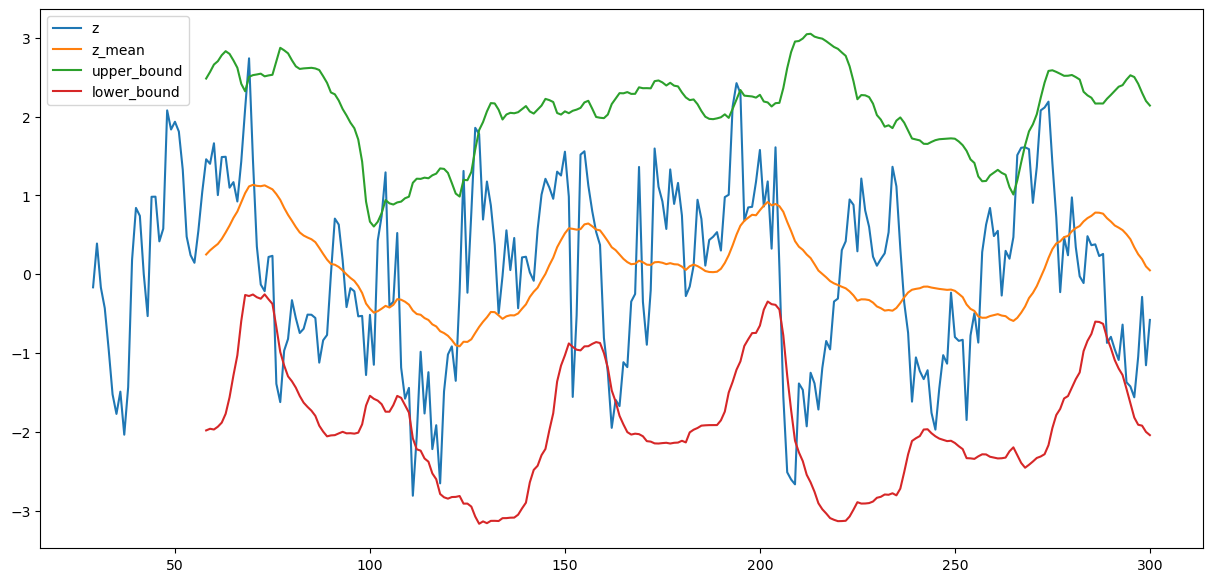

In [8]:
# plt.figure(figsize=(15, 7))
# # Set x-axis range from 0 to the length of the series.
# plt.xlim(0, len(z))
# plt.plot(z, label='z')
# plt.plot(z_mean, label='z_mean')
# plt.plot(upper_bound, label='upper_bound')
# plt.plot(lower_bound, label='lower_bound')
# plt.legend()

# make_subplots()
plot_basic()
_ = plt.legend()

In [9]:
long_signal = (z < lower_bound).astype(int)
short_signal = (z > upper_bound).astype(int)

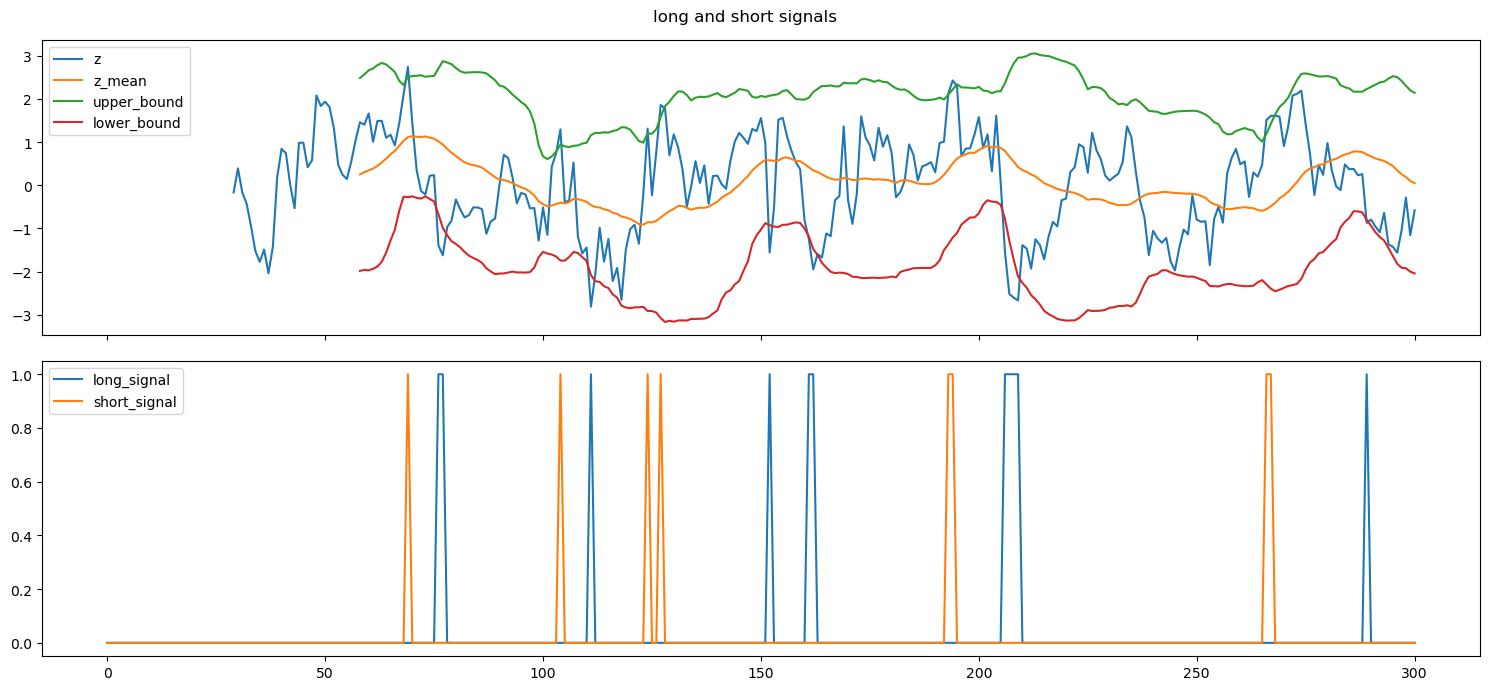

In [10]:
make_subplots(
    [long_signal, short_signal],
    ["long_signal", "short_signal"],
    "long and short signals",
)

In [11]:
position = long_signal - short_signal

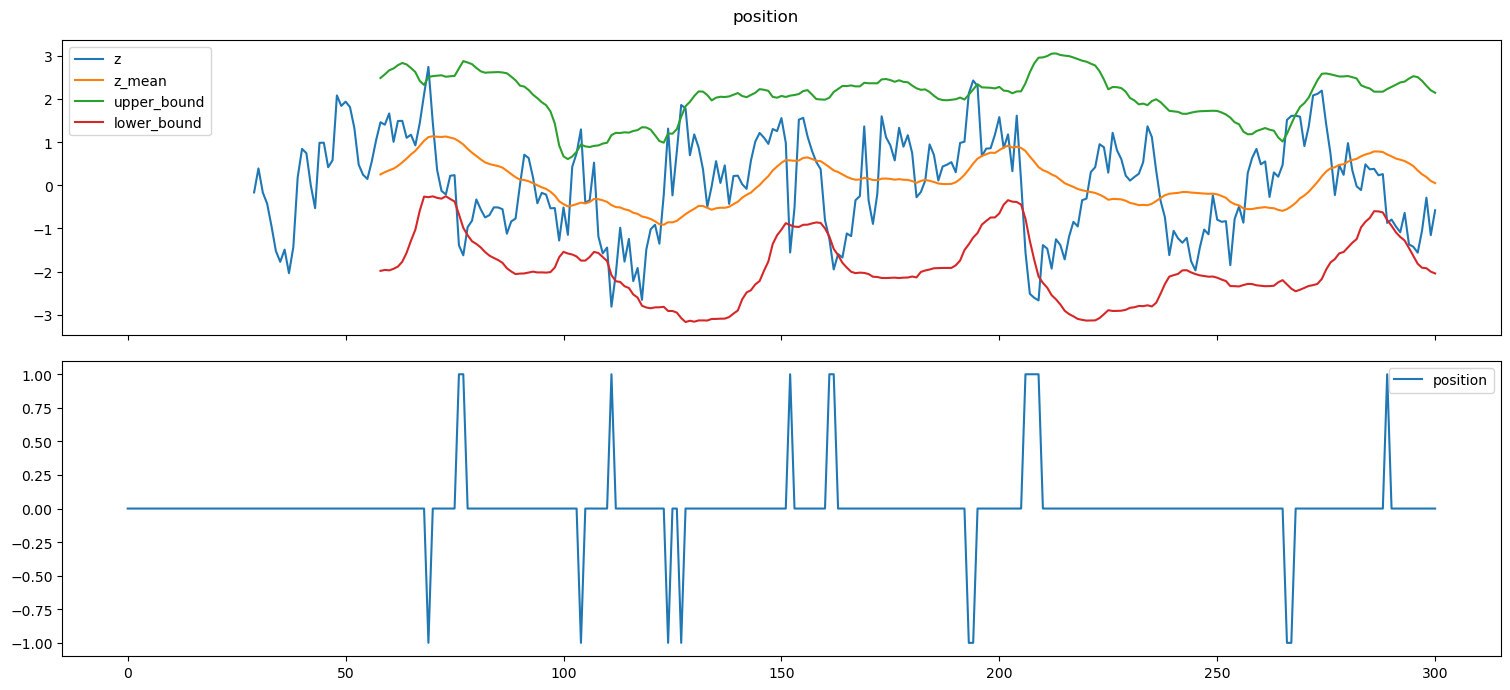

In [12]:
make_subplots(
    [position],
    ["position"],
    "position",
)

In [13]:
temp_serie = pd.Series([0, 1, 0, 0])
print(temp_serie.values)
print(temp_serie.shift(1).values)
del(temp_serie)

[0 1 0 0]
[nan  0.  1.  0.]


<AxesSubplot: >

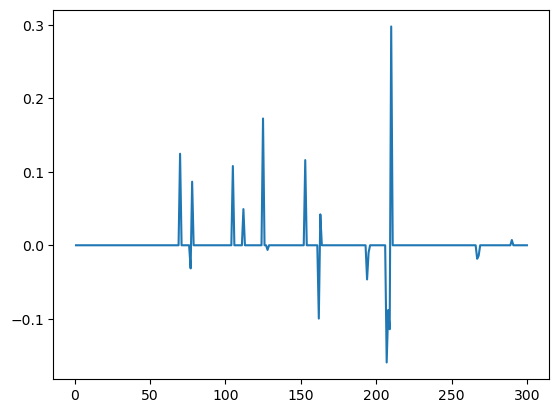

In [14]:
# Compute cumulative returns
daily_returns = position.shift(1) * series.pct_change()
daily_returns.plot()

<AxesSubplot: >

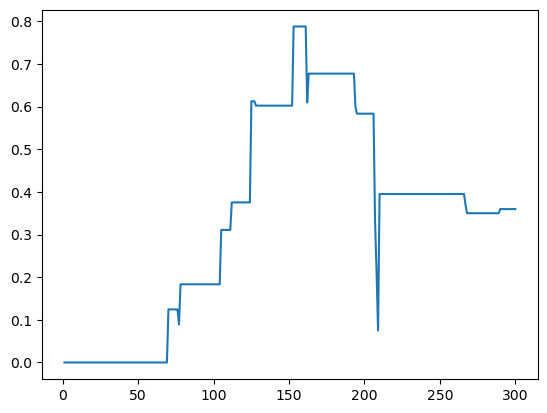

In [15]:
cumulative_returns = (1 + daily_returns).cumprod() - 1
cumulative_returns.plot()

In [16]:
def fill_position(position, way: Literal["bruno", "instructor"] = "bruno"):
    """
    This function fills the 'position' data based on the specified 'way'.
    If 'way' is 'bruno', it replaces zeros with the last valid observation.
    If 'way' is 'instructor', it replaces zeros with NaN and then forward fills these NaNs with the last valid observation.

    Bruno's way is the correct way, because it starts with no position.T
    Instructor's way is wrong, because it starts with the first non-zero position found.

    Args:
        position (pd.Series): The original data series that needs to be filled.
        way (str, optional): The method to fill the 'position'. It can be either 'bruno' or 'instructor'. Defaults to 'bruno'.

    Returns:
        pd.Series: The filled 'position' data series.
    """
    if way == "bruno":
        position_filled = position.replace(to_replace=0, method="ffill")
    elif way == "instructor":
        position_filled = position.copy()
        position_filled[position_filled == 0] = np.nan
        position_filled = position_filled.ffill()
    return position_filled


position_filled = fill_position(position, way="bruno")

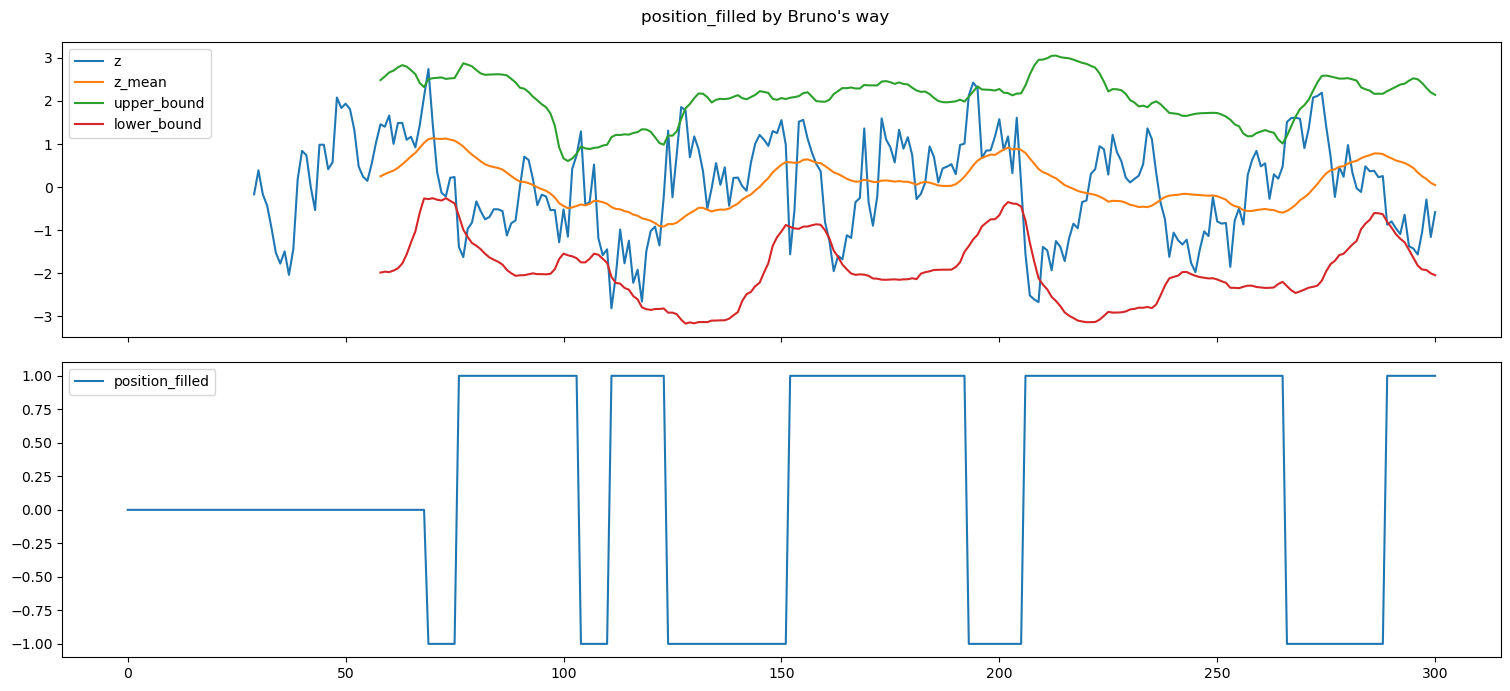

In [17]:
make_subplots(
    [position_filled],
    ["position_filled"],
    "position_filled by Bruno's way",
)

In [18]:
# instructors's way to fill the position
position_filled = fill_position(position, way='instructor')

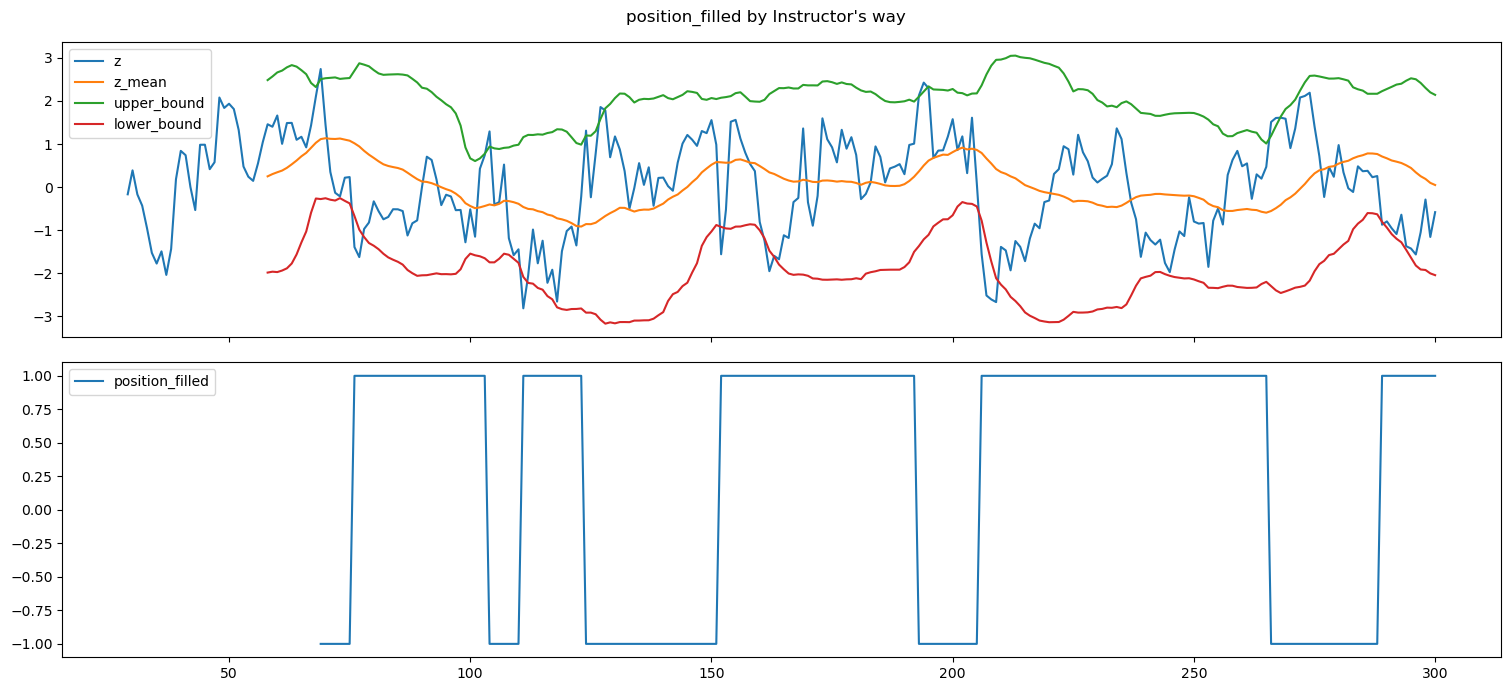

In [19]:
make_subplots(
    [position_filled],
    ["position_filled"],
    "position_filled by Instructor's way",
)

In [20]:
# So let's use the bruno's position_filled
position_filled = fill_position(position, way='bruno')